## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [3]:
## Load in the data set (Internet Access needed)
import requests
import io

       
#url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(777, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
303,0,161.0,50.0,0.0,0.0,21.9,0.254,65.0,0.0
656,0,179.0,50.0,36.0,159.0,37.8,0.455,22.0,1.0
137,1,117.0,88.0,24.0,145.0,34.5,0.403,40.0,1.0
323,7,109.0,80.0,31.0,0.0,35.9,1.127,43.0,1.0
75,0,109.0,88.0,30.0,0.0,32.5,0.855,38.0,1.0


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

print(len(X))
print(len(y))
X = X[9:]
y = y[9:]


777
777


In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)


In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

__Note:__ AUROC is a figure for comparing **false positive rate** to **true positive rate**. To know more about how to calculate AUROC refer to __[here](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it)__.


In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)

# predict(X)
# Predict class for X.
# predict_proba(X)
# Predict class probabilities for X.

y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

# Below two results should be equal for big data sets.
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_rf)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_rf[:,1])))

accuracy is 0.760
roc-auc is 0.832


Below code will generate AUROC plot for the random forest prediction result.<br>
The **Accuracy** in AUROC is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless. <br>
The x axis is the **False positive rate (FPR)** and the y axis is the **True positive rate (TPR)**. Check this __[Ref](http://gim.unmc.edu/dxtests/roc3.htm)__ for more details.

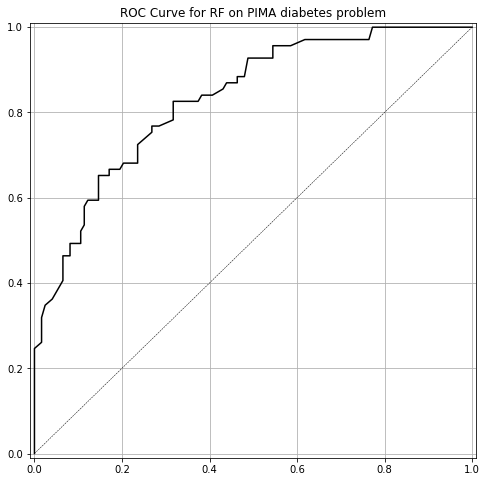

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])


plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 12 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

## The StandardScaler assumes your data is normally distributed within each feature and will scale them such 
## that the distribution is now centred around 0, with a standard deviation of 1.


normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)


C:\Conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Conda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential([
    Dense(12, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 121 parameters?  Does that make sense?


Let's fit our model for 200 epochs.

In [14]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=200)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Instructions for updating:
Use tf.cast instead.
Train on 576 samples, validate on 192 samples
Epoch 1/200
576/576 [==============================] - 0s 740us/step - loss: 0.9340 - acc: 0.3264 - val_loss: 0.8772 - val_acc: 0.3646
Epoch 2/200
576/576 [==============================] - 0s 38us/step - loss: 0.9139 - acc: 0.3351 - val_loss: 0.8618 - val_acc: 0.3646
Epoch 3/200
576/576 [==============================] - 0s 38us/step - loss: 0.8951 - acc: 0.3351 - val_loss: 0.8474 - val_acc: 0.3542
Epoch 4/200
576/576 [==============================] - 0s 42us/step - loss: 0.8775 - acc: 0.3455 - val_loss: 0.8340 - val_acc: 0.3594
Epoch 5/200
576/576 [==============================] - 0s 38us/step - loss: 0.8612 - acc: 0.3698 - val_loss: 0.8214 - val_acc: 0.3698
Epoch 6/200
576/576 [==============================] - 0s 43us/step - loss: 0.8458 - acc: 0.3802 - val_loss: 0.8096 - val_acc: 0.3802
Epoch 7/200
576/576 [==============================] - 0s 37us/step - loss: 0.8314 - acc: 0.3785 - va

576/576 [==============================] - 0s 40us/step - loss: 0.5094 - acc: 0.7569 - val_loss: 0.5291 - val_acc: 0.7552
Epoch 120/200
576/576 [==============================] - 0s 42us/step - loss: 0.5088 - acc: 0.7569 - val_loss: 0.5285 - val_acc: 0.7552
Epoch 121/200
576/576 [==============================] - 0s 38us/step - loss: 0.5082 - acc: 0.7552 - val_loss: 0.5280 - val_acc: 0.7552
Epoch 122/200
576/576 [==============================] - 0s 36us/step - loss: 0.5076 - acc: 0.7552 - val_loss: 0.5275 - val_acc: 0.7552
Epoch 123/200
576/576 [==============================] - 0s 36us/step - loss: 0.5070 - acc: 0.7552 - val_loss: 0.5270 - val_acc: 0.7604
Epoch 124/200
576/576 [==============================] - 0s 38us/step - loss: 0.5063 - acc: 0.7552 - val_loss: 0.5265 - val_acc: 0.7604
Epoch 125/200
576/576 [==============================] - 0s 36us/step - loss: 0.5058 - acc: 0.7535 - val_loss: 0.5261 - val_acc: 0.7604
Epoch 126/200
576/576 [==============================] - 0s 38

576/576 [==============================] - 0s 40us/step - loss: 0.4835 - acc: 0.7743 - val_loss: 0.5103 - val_acc: 0.7812
Epoch 180/200
576/576 [==============================] - 0s 40us/step - loss: 0.4832 - acc: 0.7726 - val_loss: 0.5101 - val_acc: 0.7812
Epoch 181/200
576/576 [==============================] - 0s 40us/step - loss: 0.4829 - acc: 0.7726 - val_loss: 0.5099 - val_acc: 0.7812
Epoch 182/200
576/576 [==============================] - 0s 36us/step - loss: 0.4826 - acc: 0.7760 - val_loss: 0.5098 - val_acc: 0.7812
Epoch 183/200
576/576 [==============================] - 0s 36us/step - loss: 0.4823 - acc: 0.7760 - val_loss: 0.5096 - val_acc: 0.7812
Epoch 184/200
576/576 [==============================] - ETA: 0s - loss: 0.5538 - acc: 0.750 - 0s 42us/step - loss: 0.4821 - acc: 0.7743 - val_loss: 0.5095 - val_acc: 0.7812
Epoch 185/200
576/576 [==============================] - 0s 38us/step - loss: 0.4818 - acc: 0.7743 - val_loss: 0.5093 - val_acc: 0.7812
Epoch 186/200
576/576 [=

In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_class_nn_1 = model_1.predict_classes(X_test_norm)
y_pred_prob_nn_1 = model_1.predict(X_test_norm)

In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0]])

In [17]:
y_pred_prob_nn_1[:10]

array([[0.48051032],
       [0.7046775 ],
       [0.220938  ],
       [0.1712474 ],
       [0.21636963],
       [0.40717775],
       [0.08508104],
       [0.27732122],
       [0.73519886],
       [0.24163154]], dtype=float32)

accuracy is 0.781
roc-auc is 0.817


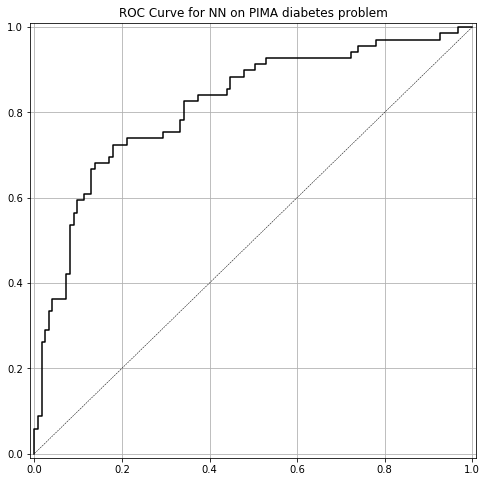

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

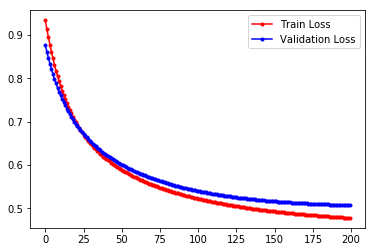

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 1000 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1000)

Train on 576 samples, validate on 192 samples
Epoch 1/1000
576/576 [==============================] - 0s 50us/step - loss: 0.4779 - acc: 0.7830 - val_loss: 0.5074 - val_acc: 0.7812
Epoch 2/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4777 - acc: 0.7847 - val_loss: 0.5073 - val_acc: 0.7812
Epoch 3/1000
576/576 [==============================] - 0s 57us/step - loss: 0.4775 - acc: 0.7847 - val_loss: 0.5072 - val_acc: 0.7812
Epoch 4/1000
576/576 [==============================] - 0s 48us/step - loss: 0.4772 - acc: 0.7847 - val_loss: 0.5071 - val_acc: 0.7812
Epoch 5/1000
576/576 [==============================] - 0s 52us/step - loss: 0.4770 - acc: 0.7847 - val_loss: 0.5070 - val_acc: 0.7812
Epoch 6/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4768 - acc: 0.7847 - val_loss: 0.5069 - val_acc: 0.7812
Epoch 7/1000
576/576 [==============================] - 0s 54us/step - loss: 0.4766 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 8/1

Epoch 61/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4677 - acc: 0.7917 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 62/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4676 - acc: 0.7917 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 63/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4675 - acc: 0.7917 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 64/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4673 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 65/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4672 - acc: 0.7899 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 66/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4671 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 67/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4669 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 68/1000
576/576 [=========================

Epoch 121/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4612 - acc: 0.7865 - val_loss: 0.5043 - val_acc: 0.7812
Epoch 122/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4611 - acc: 0.7865 - val_loss: 0.5043 - val_acc: 0.7760
Epoch 123/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4610 - acc: 0.7865 - val_loss: 0.5043 - val_acc: 0.7760
Epoch 124/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4609 - acc: 0.7865 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 125/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4609 - acc: 0.7865 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 126/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4608 - acc: 0.7865 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 127/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4607 - acc: 0.7865 - val_loss: 0.5044 - val_acc: 0.7760
Epoch 128/1000
576/576 [=================

Epoch 181/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4569 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 182/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4568 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 183/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4568 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 184/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4567 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 185/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4567 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 186/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4566 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 187/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4565 - acc: 0.7847 - val_loss: 0.5050 - val_acc: 0.7865
Epoch 188/1000
576/576 [=================

Epoch 241/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4537 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 242/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4536 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 243/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4536 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 244/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4535 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 245/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4535 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 246/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4535 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 247/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4535 - acc: 0.7847 - val_loss: 0.5054 - val_acc: 0.7865
Epoch 248/1000
576/576 [=================

Epoch 301/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4512 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 302/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4512 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 303/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4512 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 304/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4511 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 305/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4511 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 306/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4511 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 307/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4510 - acc: 0.7882 - val_loss: 0.5058 - val_acc: 0.7865
Epoch 308/1000
576/576 [=================

Epoch 361/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4493 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 362/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4492 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 363/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4492 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 364/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4492 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 365/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4491 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 366/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4491 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 367/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4491 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7865
Epoch 368/1000
576/576 [=================

Epoch 421/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4473 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 422/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4473 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 423/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4473 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 424/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4472 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 425/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4472 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 426/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4471 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 427/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4471 - acc: 0.7899 - val_loss: 0.5063 - val_acc: 0.7865
Epoch 428/1000
576/576 [=================

Epoch 481/1000
576/576 [==============================] - 0s 47us/step - loss: 0.4453 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 482/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4452 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 483/1000
576/576 [==============================] - 0s 80us/step - loss: 0.4452 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 484/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4452 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 485/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4451 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 486/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4451 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 487/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4451 - acc: 0.7865 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 488/1000
576/576 [=================

Epoch 600/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4413 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 601/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4413 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 602/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4413 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 603/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4413 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 604/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4412 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 605/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4412 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 606/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4411 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7812
Epoch 607/1000
576/576 [=================

Epoch 719/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4382 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 720/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4381 - acc: 0.7847 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 721/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4381 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 722/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4381 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 723/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4381 - acc: 0.7865 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 724/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4381 - acc: 0.7847 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 725/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4380 - acc: 0.7847 - val_loss: 0.5068 - val_acc: 0.7760
Epoch 726/1000
576/576 [=================

Epoch 779/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4366 - acc: 0.7865 - val_loss: 0.5062 - val_acc: 0.7656
Epoch 780/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4366 - acc: 0.7865 - val_loss: 0.5062 - val_acc: 0.7656
Epoch 781/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4366 - acc: 0.7882 - val_loss: 0.5062 - val_acc: 0.7656
Epoch 782/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4365 - acc: 0.7882 - val_loss: 0.5061 - val_acc: 0.7656
Epoch 783/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4365 - acc: 0.7882 - val_loss: 0.5061 - val_acc: 0.7656
Epoch 784/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4365 - acc: 0.7882 - val_loss: 0.5061 - val_acc: 0.7656
Epoch 785/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4364 - acc: 0.7865 - val_loss: 0.5061 - val_acc: 0.7656
Epoch 786/1000
576/576 [=================

Epoch 839/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4349 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 840/1000
576/576 [==============================] - 0s 35us/step - loss: 0.4349 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 841/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4348 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 842/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4348 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 843/1000
576/576 [==============================] - 0s 36us/step - loss: 0.4347 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 844/1000
576/576 [==============================] - 0s 38us/step - loss: 0.4347 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 845/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4347 - acc: 0.7865 - val_loss: 0.5056 - val_acc: 0.7865
Epoch 846/1000
576/576 [=================

Epoch 899/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4332 - acc: 0.7882 - val_loss: 0.5052 - val_acc: 0.7708
Epoch 900/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4332 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7708
Epoch 901/1000
576/576 [==============================] - ETA: 0s - loss: 0.5126 - acc: 0.656 - 0s 43us/step - loss: 0.4331 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7708
Epoch 902/1000
576/576 [==============================] - 0s 40us/step - loss: 0.4331 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7708
Epoch 903/1000
576/576 [==============================] - 0s 42us/step - loss: 0.4331 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7708
Epoch 904/1000
576/576 [==============================] - 0s 43us/step - loss: 0.4330 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7760
Epoch 905/1000
576/576 [==============================] - 0s 45us/step - loss: 0.4330 - acc: 0.7899 - val_loss: 0.5052 - val_acc: 0.7760
Epo

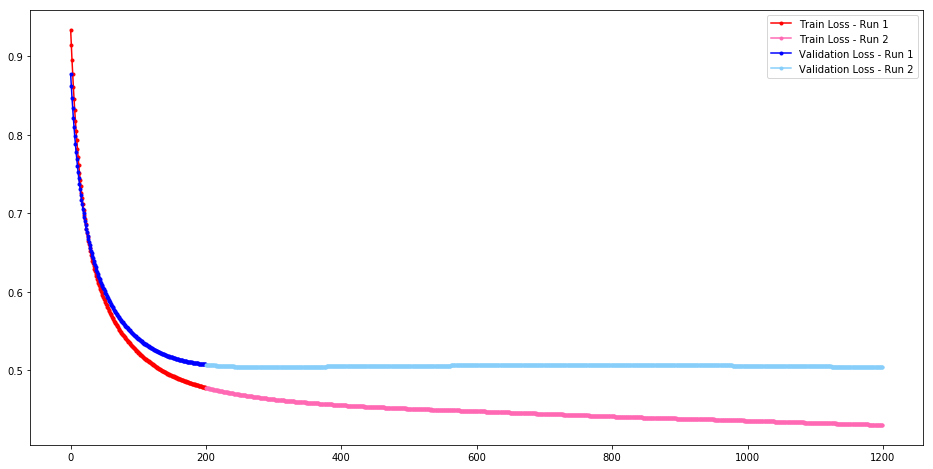

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

## Exercise
Now it's your turn.  Do the following in the cells below:
- Build a model with two hidden layers, each with 6 nodes
- Use the "relu" activation function for the hidden layers, and "sigmoid" for the final layer
- Use a learning rate of .003 and train for 1500 epochs
- Graph the trajectory of the loss functions, accuracy on both train and test set
- Plot the roc curve for the predictions

Experiment with different learning rates, numbers of epochs, and network structures

## Your Answer

In [27]:
#Creating Model with 2 hidden layers, each has 6 nodes and relu activation 
#The final layers has 1 node and sigmoid activation

model_2 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, input_shape=(8,),activation="relu"), 
    Dense(1, activation="sigmoid")
]) 

#This function summarizes the details of the model 
model_2.summary()

#Compiling the model with lr=0.003, training for 1500 epochs 
model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
Train on 576 samples, validate on 192 samples
Epoch 1/1500
576/576 [==============================] - 1s 897us/step - loss: 0.6126 - acc: 0.6545 - val_loss: 0.6279 - val_acc: 0.6406
Epoch 2/1500
576/576 [==============================] - 0s 38us/step - loss: 0.6104 - acc: 0.6545 - val_loss: 0.6261 - val_acc: 0.6406
Epoch 3/1500
576/576 [==============================] - 0s 47us/step - loss: 0.6082 - acc: 

576/576 [==============================] - 0s 48us/step - loss: 0.5030 - acc: 0.7170 - val_loss: 0.5571 - val_acc: 0.6979
Epoch 116/1500
576/576 [==============================] - 0s 54us/step - loss: 0.5027 - acc: 0.7188 - val_loss: 0.5570 - val_acc: 0.6979
Epoch 117/1500
576/576 [==============================] - 0s 55us/step - loss: 0.5023 - acc: 0.7205 - val_loss: 0.5568 - val_acc: 0.7031
Epoch 118/1500
576/576 [==============================] - 0s 48us/step - loss: 0.5020 - acc: 0.7205 - val_loss: 0.5567 - val_acc: 0.7031
Epoch 119/1500
576/576 [==============================] - 0s 47us/step - loss: 0.5016 - acc: 0.7222 - val_loss: 0.5566 - val_acc: 0.7083
Epoch 120/1500
576/576 [==============================] - 0s 48us/step - loss: 0.5013 - acc: 0.7222 - val_loss: 0.5564 - val_acc: 0.7135
Epoch 121/1500
576/576 [==============================] - 0s 47us/step - loss: 0.5010 - acc: 0.7222 - val_loss: 0.5563 - val_acc: 0.7135
Epoch 122/1500
576/576 [==============================] 

Epoch 175/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4869 - acc: 0.7604 - val_loss: 0.5515 - val_acc: 0.7240
Epoch 176/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4867 - acc: 0.7604 - val_loss: 0.5514 - val_acc: 0.7240
Epoch 177/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4865 - acc: 0.7604 - val_loss: 0.5514 - val_acc: 0.7240
Epoch 178/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4863 - acc: 0.7622 - val_loss: 0.5513 - val_acc: 0.7240
Epoch 179/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4861 - acc: 0.7622 - val_loss: 0.5512 - val_acc: 0.7240
Epoch 180/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4859 - acc: 0.7622 - val_loss: 0.5512 - val_acc: 0.7240
Epoch 181/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4857 - acc: 0.7622 - val_loss: 0.5511 - val_acc: 0.7240
Epoch 182/1500
576/576 [=================

Epoch 235/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4764 - acc: 0.7639 - val_loss: 0.5493 - val_acc: 0.7188
Epoch 236/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4763 - acc: 0.7639 - val_loss: 0.5493 - val_acc: 0.7240
Epoch 237/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4762 - acc: 0.7639 - val_loss: 0.5493 - val_acc: 0.7240
Epoch 238/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4760 - acc: 0.7639 - val_loss: 0.5493 - val_acc: 0.7240
Epoch 239/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4758 - acc: 0.7639 - val_loss: 0.5493 - val_acc: 0.7240
Epoch 240/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4757 - acc: 0.7639 - val_loss: 0.5492 - val_acc: 0.7240
Epoch 241/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4756 - acc: 0.7639 - val_loss: 0.5492 - val_acc: 0.7292
Epoch 242/1500
576/576 [=================

Epoch 295/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4687 - acc: 0.7743 - val_loss: 0.5487 - val_acc: 0.7292
Epoch 296/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4686 - acc: 0.7743 - val_loss: 0.5487 - val_acc: 0.7292
Epoch 297/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4684 - acc: 0.7743 - val_loss: 0.5486 - val_acc: 0.7292
Epoch 298/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4683 - acc: 0.7743 - val_loss: 0.5486 - val_acc: 0.7292
Epoch 299/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4682 - acc: 0.7743 - val_loss: 0.5485 - val_acc: 0.7292
Epoch 300/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4681 - acc: 0.7743 - val_loss: 0.5485 - val_acc: 0.7292
Epoch 301/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4679 - acc: 0.7760 - val_loss: 0.5485 - val_acc: 0.7292
Epoch 302/1500
576/576 [=================

Epoch 355/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4620 - acc: 0.7708 - val_loss: 0.5470 - val_acc: 0.7344
Epoch 356/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4619 - acc: 0.7708 - val_loss: 0.5469 - val_acc: 0.7344
Epoch 357/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4618 - acc: 0.7708 - val_loss: 0.5469 - val_acc: 0.7344
Epoch 358/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4617 - acc: 0.7708 - val_loss: 0.5469 - val_acc: 0.7344
Epoch 359/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4616 - acc: 0.7726 - val_loss: 0.5469 - val_acc: 0.7344
Epoch 360/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4616 - acc: 0.7726 - val_loss: 0.5468 - val_acc: 0.7344
Epoch 361/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4615 - acc: 0.7726 - val_loss: 0.5468 - val_acc: 0.7344
Epoch 362/1500
576/576 [=================

Epoch 415/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4574 - acc: 0.7865 - val_loss: 0.5471 - val_acc: 0.7292
Epoch 416/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4574 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 417/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4573 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 418/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4572 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 419/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4572 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 420/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4571 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 421/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4570 - acc: 0.7865 - val_loss: 0.5472 - val_acc: 0.7292
Epoch 422/1500
576/576 [=================

Epoch 475/1500
576/576 [==============================] - 0s 27us/step - loss: 0.4538 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 476/1500
576/576 [==============================] - 0s 54us/step - loss: 0.4538 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 477/1500
576/576 [==============================] - 0s 53us/step - loss: 0.4537 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 478/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4537 - acc: 0.7882 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 479/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4536 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 480/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4535 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 481/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4535 - acc: 0.7865 - val_loss: 0.5477 - val_acc: 0.7448
Epoch 482/1500
576/576 [=================

Epoch 535/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4507 - acc: 0.7882 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 536/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4507 - acc: 0.7882 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 537/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4507 - acc: 0.7865 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 538/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4506 - acc: 0.7882 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 539/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4506 - acc: 0.7865 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 540/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4506 - acc: 0.7865 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 541/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4505 - acc: 0.7865 - val_loss: 0.5483 - val_acc: 0.7448
Epoch 542/1500
576/576 [=================

Epoch 595/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4481 - acc: 0.7899 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 596/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4481 - acc: 0.7917 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 597/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4481 - acc: 0.7917 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 598/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4480 - acc: 0.7917 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 599/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4480 - acc: 0.7917 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 600/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4479 - acc: 0.7917 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 601/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4479 - acc: 0.7899 - val_loss: 0.5491 - val_acc: 0.7396
Epoch 602/1500
576/576 [=================

Epoch 655/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4459 - acc: 0.7969 - val_loss: 0.5497 - val_acc: 0.7344
Epoch 656/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4458 - acc: 0.7969 - val_loss: 0.5497 - val_acc: 0.7344
Epoch 657/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4458 - acc: 0.7969 - val_loss: 0.5497 - val_acc: 0.7344
Epoch 658/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4458 - acc: 0.7969 - val_loss: 0.5498 - val_acc: 0.7344
Epoch 659/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4458 - acc: 0.7969 - val_loss: 0.5498 - val_acc: 0.7344
Epoch 660/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4457 - acc: 0.7969 - val_loss: 0.5498 - val_acc: 0.7344
Epoch 661/1500
576/576 [==============================] - 0s 36us/step - loss: 0.4457 - acc: 0.7969 - val_loss: 0.5498 - val_acc: 0.7344
Epoch 662/1500
576/576 [=================

Epoch 715/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4438 - acc: 0.7951 - val_loss: 0.5510 - val_acc: 0.7344
Epoch 716/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4438 - acc: 0.7951 - val_loss: 0.5510 - val_acc: 0.7344
Epoch 717/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4437 - acc: 0.7934 - val_loss: 0.5511 - val_acc: 0.7344
Epoch 718/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4437 - acc: 0.7951 - val_loss: 0.5511 - val_acc: 0.7344
Epoch 719/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4437 - acc: 0.7951 - val_loss: 0.5511 - val_acc: 0.7344
Epoch 720/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4436 - acc: 0.7934 - val_loss: 0.5511 - val_acc: 0.7344
Epoch 721/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4436 - acc: 0.7934 - val_loss: 0.5511 - val_acc: 0.7344
Epoch 722/1500
576/576 [=================

Epoch 775/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4420 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 776/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4419 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 777/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4419 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 778/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4419 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 779/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4418 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 780/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4418 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 781/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4418 - acc: 0.7951 - val_loss: 0.5516 - val_acc: 0.7344
Epoch 782/1500
576/576 [=================

Epoch 835/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4399 - acc: 0.7969 - val_loss: 0.5515 - val_acc: 0.7344
Epoch 836/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4399 - acc: 0.7969 - val_loss: 0.5515 - val_acc: 0.7344
Epoch 837/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4398 - acc: 0.7969 - val_loss: 0.5515 - val_acc: 0.7344
Epoch 838/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4398 - acc: 0.7969 - val_loss: 0.5515 - val_acc: 0.7344
Epoch 839/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4398 - acc: 0.7969 - val_loss: 0.5514 - val_acc: 0.7344
Epoch 840/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4397 - acc: 0.7969 - val_loss: 0.5514 - val_acc: 0.7344
Epoch 841/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4397 - acc: 0.7969 - val_loss: 0.5514 - val_acc: 0.7344
Epoch 842/1500
576/576 [=================

Epoch 895/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4379 - acc: 0.7986 - val_loss: 0.5513 - val_acc: 0.7396
Epoch 896/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4379 - acc: 0.7969 - val_loss: 0.5513 - val_acc: 0.7396
Epoch 897/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4379 - acc: 0.7969 - val_loss: 0.5513 - val_acc: 0.7396
Epoch 898/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4379 - acc: 0.7969 - val_loss: 0.5512 - val_acc: 0.7396
Epoch 899/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4378 - acc: 0.7969 - val_loss: 0.5513 - val_acc: 0.7396
Epoch 900/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4378 - acc: 0.7969 - val_loss: 0.5513 - val_acc: 0.7396
Epoch 901/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4377 - acc: 0.7969 - val_loss: 0.5513 - val_acc: 0.7344
Epoch 902/1500
576/576 [=================

Epoch 955/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4360 - acc: 0.8003 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 956/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4360 - acc: 0.7986 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 957/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4359 - acc: 0.8003 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 958/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4359 - acc: 0.8021 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 959/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4359 - acc: 0.8021 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 960/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4358 - acc: 0.8003 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 961/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4358 - acc: 0.8021 - val_loss: 0.5514 - val_acc: 0.7292
Epoch 962/1500
576/576 [=================

Epoch 1015/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4343 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1016/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4343 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1017/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4342 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1018/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4342 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1019/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4341 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1020/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4341 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1021/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4341 - acc: 0.8021 - val_loss: 0.5517 - val_acc: 0.7292
Epoch 1022/1500
576/576 [=========

576/576 [==============================] - 0s 43us/step - loss: 0.4309 - acc: 0.8038 - val_loss: 0.5518 - val_acc: 0.7240
Epoch 1134/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4308 - acc: 0.8021 - val_loss: 0.5518 - val_acc: 0.7240
Epoch 1135/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4308 - acc: 0.8038 - val_loss: 0.5518 - val_acc: 0.7240
Epoch 1136/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4308 - acc: 0.8038 - val_loss: 0.5517 - val_acc: 0.7240
Epoch 1137/1500
576/576 [==============================] - 0s 39us/step - loss: 0.4307 - acc: 0.8038 - val_loss: 0.5517 - val_acc: 0.7240
Epoch 1138/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4307 - acc: 0.8038 - val_loss: 0.5517 - val_acc: 0.7240
Epoch 1139/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4307 - acc: 0.8038 - val_loss: 0.5517 - val_acc: 0.7240
Epoch 1140/1500
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.4272 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1252/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4272 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1253/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4272 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1254/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4271 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1255/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4272 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1256/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4271 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1257/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4270 - acc: 0.8038 - val_loss: 0.5506 - val_acc: 0.7344
Epoch 1258/1500
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.4242 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1370/1500
576/576 [==============================] - 0s 43us/step - loss: 0.4242 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1371/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4242 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1372/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4242 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1373/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4242 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1374/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4241 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1375/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4241 - acc: 0.8056 - val_loss: 0.5508 - val_acc: 0.7396
Epoch 1376/1500
576/576 [=========================

576/576 [==============================] - 0s 45us/step - loss: 0.4216 - acc: 0.8108 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1488/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4216 - acc: 0.8108 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1489/1500
576/576 [==============================] - 0s 38us/step - loss: 0.4216 - acc: 0.8090 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1490/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4216 - acc: 0.8090 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1491/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4216 - acc: 0.8108 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1492/1500
576/576 [==============================] - 0s 40us/step - loss: 0.4215 - acc: 0.8108 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1493/1500
576/576 [==============================] - 0s 42us/step - loss: 0.4215 - acc: 0.8108 - val_loss: 0.5505 - val_acc: 0.7396
Epoch 1494/1500
576/576 [=========================

Text(0.5, 1.0, 'Accuracy over iterations')

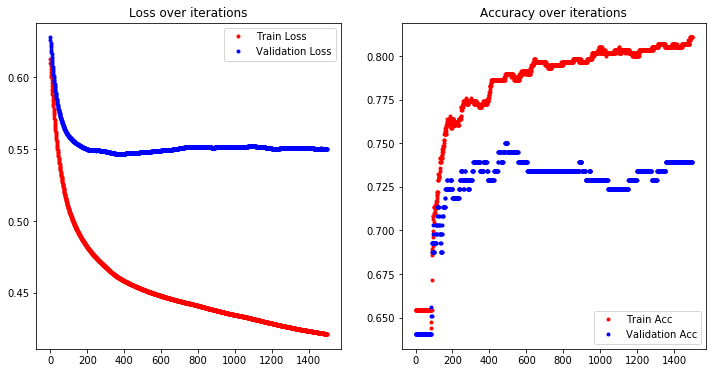

In [28]:
n = len(run_hist_2.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_2.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_2.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_2.history["acc"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_2.history["val_acc"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')


accuracy is 0.740
roc-auc is 0.798


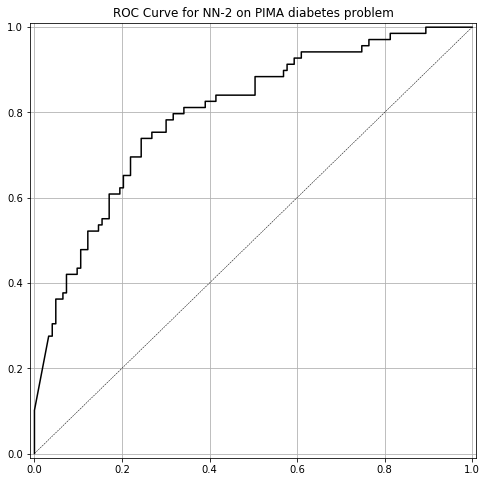

In [29]:
y_pred_class_nn_2 = model_2.predict_classes(X_test_norm)
y_pred_prob_nn_2 = model_2.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN-2')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
Train on 576 samples, validate on 192 samples
Epoch 1/500
576/576 [==============================] - 1s 990us/step - loss: 0.8442 - acc: 0.4358 - val_loss: 0.8241 - val_acc: 0.4115
Epoch 2/500
576/576 [==============================] - 0s 42us/step - loss: 0.8229 - acc: 0.4479 - val_loss: 0.8039 - val_acc: 0.4219
Epoch 3/500
576/576 [==============================] - 0s 47us/step - loss: 0.8046 - acc: 0.4

576/576 [==============================] - 0s 36us/step - loss: 0.6026 - acc: 0.6562 - val_loss: 0.6010 - val_acc: 0.6458
Epoch 57/500
576/576 [==============================] - 0s 43us/step - loss: 0.6009 - acc: 0.6562 - val_loss: 0.5996 - val_acc: 0.6458
Epoch 58/500
576/576 [==============================] - 0s 43us/step - loss: 0.5994 - acc: 0.6562 - val_loss: 0.5983 - val_acc: 0.6458
Epoch 59/500
576/576 [==============================] - 0s 40us/step - loss: 0.5978 - acc: 0.6562 - val_loss: 0.5969 - val_acc: 0.6458
Epoch 60/500
576/576 [==============================] - 0s 43us/step - loss: 0.5963 - acc: 0.6562 - val_loss: 0.5956 - val_acc: 0.6458
Epoch 61/500
576/576 [==============================] - 0s 38us/step - loss: 0.5946 - acc: 0.6562 - val_loss: 0.5942 - val_acc: 0.6458
Epoch 62/500
576/576 [==============================] - 0s 43us/step - loss: 0.5930 - acc: 0.6562 - val_loss: 0.5930 - val_acc: 0.6458
Epoch 63/500
576/576 [==============================] - 0s 43us/step

576/576 [==============================] - 0s 40us/step - loss: 0.4655 - acc: 0.7760 - val_loss: 0.5194 - val_acc: 0.7240
Epoch 177/500
576/576 [==============================] - 0s 42us/step - loss: 0.4650 - acc: 0.7778 - val_loss: 0.5192 - val_acc: 0.7240
Epoch 178/500
576/576 [==============================] - 0s 43us/step - loss: 0.4645 - acc: 0.7778 - val_loss: 0.5190 - val_acc: 0.7240
Epoch 179/500
576/576 [==============================] - 0s 40us/step - loss: 0.4640 - acc: 0.7778 - val_loss: 0.5188 - val_acc: 0.7240
Epoch 180/500
576/576 [==============================] - 0s 40us/step - loss: 0.4635 - acc: 0.7778 - val_loss: 0.5186 - val_acc: 0.7240
Epoch 181/500
576/576 [==============================] - 0s 42us/step - loss: 0.4631 - acc: 0.7795 - val_loss: 0.5185 - val_acc: 0.7292
Epoch 182/500
576/576 [==============================] - 0s 40us/step - loss: 0.4625 - acc: 0.7795 - val_loss: 0.5184 - val_acc: 0.7292
Epoch 183/500
576/576 [==============================] - 0s 42

576/576 [==============================] - 0s 43us/step - loss: 0.4371 - acc: 0.7812 - val_loss: 0.5057 - val_acc: 0.7292
Epoch 297/500
576/576 [==============================] - 0s 43us/step - loss: 0.4369 - acc: 0.7830 - val_loss: 0.5058 - val_acc: 0.7292
Epoch 298/500
576/576 [==============================] - 0s 43us/step - loss: 0.4368 - acc: 0.7847 - val_loss: 0.5057 - val_acc: 0.7292
Epoch 299/500
576/576 [==============================] - 0s 40us/step - loss: 0.4367 - acc: 0.7830 - val_loss: 0.5057 - val_acc: 0.7292
Epoch 300/500
576/576 [==============================] - 0s 43us/step - loss: 0.4366 - acc: 0.7812 - val_loss: 0.5057 - val_acc: 0.7292
Epoch 301/500
576/576 [==============================] - 0s 42us/step - loss: 0.4366 - acc: 0.7847 - val_loss: 0.5056 - val_acc: 0.7292
Epoch 302/500
576/576 [==============================] - 0s 43us/step - loss: 0.4364 - acc: 0.7847 - val_loss: 0.5056 - val_acc: 0.7292
Epoch 303/500
576/576 [==============================] - 0s 42

576/576 [==============================] - 0s 43us/step - loss: 0.4260 - acc: 0.7899 - val_loss: 0.5072 - val_acc: 0.7396
Epoch 417/500
576/576 [==============================] - 0s 52us/step - loss: 0.4260 - acc: 0.7899 - val_loss: 0.5073 - val_acc: 0.7396
Epoch 418/500
576/576 [==============================] - 0s 43us/step - loss: 0.4258 - acc: 0.7899 - val_loss: 0.5073 - val_acc: 0.7396
Epoch 419/500
576/576 [==============================] - 0s 42us/step - loss: 0.4259 - acc: 0.7917 - val_loss: 0.5073 - val_acc: 0.7396
Epoch 420/500
576/576 [==============================] - 0s 50us/step - loss: 0.4257 - acc: 0.7899 - val_loss: 0.5073 - val_acc: 0.7396
Epoch 421/500
576/576 [==============================] - 0s 42us/step - loss: 0.4256 - acc: 0.7917 - val_loss: 0.5074 - val_acc: 0.7396
Epoch 422/500
576/576 [==============================] - 0s 50us/step - loss: 0.4255 - acc: 0.7917 - val_loss: 0.5074 - val_acc: 0.7396
Epoch 423/500
576/576 [==============================] - 0s 52

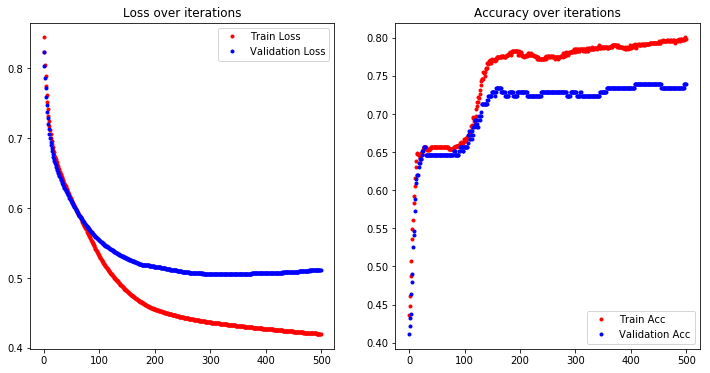

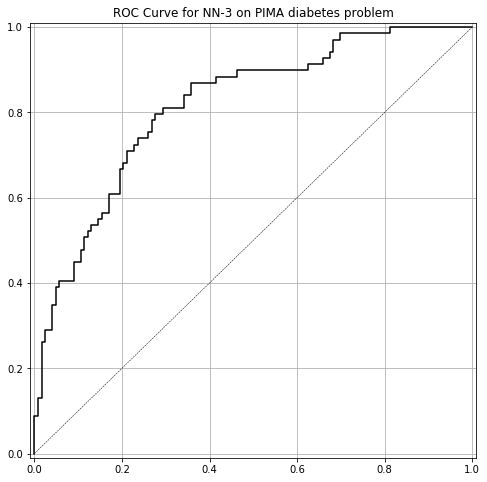

In [31]:
#experimenting with different values

#Creating Model with 2 hidden layers, each has 6 nodes and relu activation 
#The final layers has 1 node and sigmoid activation

model_3 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, input_shape=(8,),activation="relu"), 
    Dense(1, activation="sigmoid")
]) 

#This function summarizes the details of the model 
model_3.summary()

#Experimenting with a new learning rate and a different number of epochs
#Compiling the model with lr=0.006, training for 500 epochs 
model_3.compile(SGD(lr = .006), "binary_crossentropy", metrics=["accuracy"])
run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=500)


#plotting values 
n = len(run_hist_3.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_3.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_3.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_3.history["acc"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_3.history["val_acc"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

y_pred_class_nn_3 = model_3.predict_classes(X_test_norm)
y_pred_prob_nn_3 = model_3.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3)))

plot_roc(y_test, y_pred_prob_nn_3, 'NN-3')




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 7         
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________
Train on 576 samples, validate on 192 samples
Epoch 1/3000
576/576 [==============================] - 1s 1ms/step - loss: 0.7086 - acc: 0.5694 - val_loss: 0.7159 - val_acc: 0.5885
Epoch 2/3000
576/576 [==============================] - 0s 43us/step - loss: 0.7067 - acc: 0.5816 - val_loss: 0.7140 - val_acc: 0.5885
Epoch 3/3000
576/576 [==============================] - 0s 43us/step - loss: 0.7048 - acc: 0.

576/576 [==============================] - 0s 43us/step - loss: 0.5852 - acc: 0.7222 - val_loss: 0.5893 - val_acc: 0.7083
Epoch 116/3000
576/576 [==============================] - 0s 47us/step - loss: 0.5844 - acc: 0.7222 - val_loss: 0.5885 - val_acc: 0.7135
Epoch 117/3000
576/576 [==============================] - 0s 47us/step - loss: 0.5837 - acc: 0.7222 - val_loss: 0.5878 - val_acc: 0.7135
Epoch 118/3000
576/576 [==============================] - 0s 47us/step - loss: 0.5830 - acc: 0.7205 - val_loss: 0.5870 - val_acc: 0.7135
Epoch 119/3000
576/576 [==============================] - 0s 42us/step - loss: 0.5822 - acc: 0.7222 - val_loss: 0.5863 - val_acc: 0.7135
Epoch 120/3000
576/576 [==============================] - 0s 43us/step - loss: 0.5815 - acc: 0.7240 - val_loss: 0.5855 - val_acc: 0.7135
Epoch 121/3000
576/576 [==============================] - 0s 40us/step - loss: 0.5808 - acc: 0.7257 - val_loss: 0.5848 - val_acc: 0.7135
Epoch 122/3000
576/576 [==============================] 

Epoch 175/3000
576/576 [==============================] - 0s 43us/step - loss: 0.5450 - acc: 0.7535 - val_loss: 0.5502 - val_acc: 0.7448
Epoch 176/3000
576/576 [==============================] - 0s 43us/step - loss: 0.5444 - acc: 0.7535 - val_loss: 0.5497 - val_acc: 0.7448
Epoch 177/3000
576/576 [==============================] - 0s 43us/step - loss: 0.5438 - acc: 0.7517 - val_loss: 0.5492 - val_acc: 0.7448
Epoch 178/3000
576/576 [==============================] - 0s 45us/step - loss: 0.5432 - acc: 0.7535 - val_loss: 0.5487 - val_acc: 0.7448
Epoch 179/3000
576/576 [==============================] - 0s 45us/step - loss: 0.5426 - acc: 0.7535 - val_loss: 0.5482 - val_acc: 0.7448
Epoch 180/3000
576/576 [==============================] - 0s 43us/step - loss: 0.5420 - acc: 0.7535 - val_loss: 0.5476 - val_acc: 0.7500
Epoch 181/3000
576/576 [==============================] - 0s 42us/step - loss: 0.5414 - acc: 0.7552 - val_loss: 0.5471 - val_acc: 0.7500
Epoch 182/3000
576/576 [=================

Epoch 235/3000
576/576 [==============================] - 0s 48us/step - loss: 0.5125 - acc: 0.7639 - val_loss: 0.5245 - val_acc: 0.7552
Epoch 236/3000
576/576 [==============================] - 0s 52us/step - loss: 0.5120 - acc: 0.7639 - val_loss: 0.5242 - val_acc: 0.7552
Epoch 237/3000
576/576 [==============================] - 0s 52us/step - loss: 0.5116 - acc: 0.7622 - val_loss: 0.5239 - val_acc: 0.7552
Epoch 238/3000
576/576 [==============================] - 0s 48us/step - loss: 0.5111 - acc: 0.7622 - val_loss: 0.5236 - val_acc: 0.7552
Epoch 239/3000
576/576 [==============================] - 0s 45us/step - loss: 0.5106 - acc: 0.7639 - val_loss: 0.5233 - val_acc: 0.7552
Epoch 240/3000
576/576 [==============================] - 0s 50us/step - loss: 0.5102 - acc: 0.7622 - val_loss: 0.5229 - val_acc: 0.7552
Epoch 241/3000
576/576 [==============================] - 0s 50us/step - loss: 0.5098 - acc: 0.7622 - val_loss: 0.5226 - val_acc: 0.7552
Epoch 242/3000
576/576 [=================

Epoch 295/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4898 - acc: 0.7604 - val_loss: 0.5101 - val_acc: 0.7604
Epoch 296/3000
576/576 [==============================] - 0s 55us/step - loss: 0.4895 - acc: 0.7604 - val_loss: 0.5099 - val_acc: 0.7604
Epoch 297/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4892 - acc: 0.7604 - val_loss: 0.5097 - val_acc: 0.7604
Epoch 298/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4889 - acc: 0.7604 - val_loss: 0.5096 - val_acc: 0.7604
Epoch 299/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4886 - acc: 0.7604 - val_loss: 0.5094 - val_acc: 0.7604
Epoch 300/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4883 - acc: 0.7604 - val_loss: 0.5093 - val_acc: 0.7604
Epoch 301/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4880 - acc: 0.7604 - val_loss: 0.5091 - val_acc: 0.7604
Epoch 302/3000
576/576 [=================

Epoch 414/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4659 - acc: 0.7743 - val_loss: 0.5021 - val_acc: 0.7552
Epoch 415/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4657 - acc: 0.7743 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 416/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4656 - acc: 0.7743 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 417/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4655 - acc: 0.7743 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 418/3000
576/576 [==============================] - 0s 52us/step - loss: 0.4653 - acc: 0.7760 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 419/3000
576/576 [==============================] - 0s 52us/step - loss: 0.4652 - acc: 0.7743 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 420/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4650 - acc: 0.7743 - val_loss: 0.5020 - val_acc: 0.7552
Epoch 421/3000
576/576 [=================

Epoch 474/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4586 - acc: 0.7847 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 475/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4585 - acc: 0.7847 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 476/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4585 - acc: 0.7865 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 477/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4583 - acc: 0.7847 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 478/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4582 - acc: 0.7847 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 479/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4581 - acc: 0.7865 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 480/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4580 - acc: 0.7865 - val_loss: 0.5013 - val_acc: 0.7552
Epoch 481/3000
576/576 [=================

Epoch 534/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4533 - acc: 0.7899 - val_loss: 0.5008 - val_acc: 0.7552
Epoch 535/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4532 - acc: 0.7899 - val_loss: 0.5008 - val_acc: 0.7552
Epoch 536/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4531 - acc: 0.7917 - val_loss: 0.5008 - val_acc: 0.7552
Epoch 537/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4530 - acc: 0.7899 - val_loss: 0.5008 - val_acc: 0.7552
Epoch 538/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4530 - acc: 0.7899 - val_loss: 0.5008 - val_acc: 0.7552
Epoch 539/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4530 - acc: 0.7882 - val_loss: 0.5008 - val_acc: 0.7500
Epoch 540/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4529 - acc: 0.7882 - val_loss: 0.5008 - val_acc: 0.7500
Epoch 541/3000
576/576 [=================

Epoch 594/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4494 - acc: 0.7830 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 595/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4493 - acc: 0.7830 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 596/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4493 - acc: 0.7847 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 597/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4492 - acc: 0.7830 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 598/3000
576/576 [==============================] - 0s 52us/step - loss: 0.4492 - acc: 0.7830 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 599/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4491 - acc: 0.7847 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 600/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4491 - acc: 0.7830 - val_loss: 0.5006 - val_acc: 0.7500
Epoch 601/3000
576/576 [=================

Epoch 654/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4464 - acc: 0.7865 - val_loss: 0.5011 - val_acc: 0.7500
Epoch 655/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4465 - acc: 0.7865 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 656/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4463 - acc: 0.7882 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 657/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4463 - acc: 0.7865 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 658/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4462 - acc: 0.7882 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 659/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4462 - acc: 0.7882 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 660/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4462 - acc: 0.7882 - val_loss: 0.5012 - val_acc: 0.7500
Epoch 661/3000
576/576 [=================

Epoch 714/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4443 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 715/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4442 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 716/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4441 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 717/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4441 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 718/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4440 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 719/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4440 - acc: 0.7899 - val_loss: 0.5018 - val_acc: 0.7500
Epoch 720/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4439 - acc: 0.7899 - val_loss: 0.5019 - val_acc: 0.7500
Epoch 721/3000
576/576 [=================

Epoch 774/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4423 - acc: 0.7899 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 775/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4423 - acc: 0.7899 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 776/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4423 - acc: 0.7899 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 777/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4422 - acc: 0.7899 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 778/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4422 - acc: 0.7899 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 779/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4422 - acc: 0.7882 - val_loss: 0.5028 - val_acc: 0.7500
Epoch 780/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4421 - acc: 0.7882 - val_loss: 0.5029 - val_acc: 0.7500
Epoch 781/3000
576/576 [=================

Epoch 834/3000
576/576 [==============================] - 0s 50us/step - loss: 0.4406 - acc: 0.7847 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 835/3000
576/576 [==============================] - 0s 49us/step - loss: 0.4405 - acc: 0.7882 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 836/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4405 - acc: 0.7899 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 837/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4405 - acc: 0.7882 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 838/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4405 - acc: 0.7917 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 839/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4405 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 840/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4404 - acc: 0.7882 - val_loss: 0.5035 - val_acc: 0.7448
Epoch 841/3000
576/576 [=================

Epoch 894/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4391 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 895/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4391 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 896/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4391 - acc: 0.7882 - val_loss: 0.5039 - val_acc: 0.7448
Epoch 897/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4391 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 898/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4391 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 899/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4391 - acc: 0.7865 - val_loss: 0.5039 - val_acc: 0.7448
Epoch 900/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4390 - acc: 0.7865 - val_loss: 0.5039 - val_acc: 0.7448
Epoch 901/3000
576/576 [=================

Epoch 954/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4378 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 955/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4378 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 956/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4378 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 957/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4378 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 958/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4377 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 959/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4377 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 960/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4377 - acc: 0.7865 - val_loss: 0.5040 - val_acc: 0.7448
Epoch 961/3000
576/576 [=================

Epoch 1014/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4366 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1015/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4366 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1016/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4365 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1017/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4365 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1018/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4364 - acc: 0.7865 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1019/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4365 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1020/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4364 - acc: 0.7899 - val_loss: 0.5036 - val_acc: 0.7552
Epoch 1021/3000
576/576 [=========

576/576 [==============================] - 0s 42us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1133/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1134/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1135/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1136/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1137/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4346 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1138/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4345 - acc: 0.7865 - val_loss: 0.5035 - val_acc: 0.7552
Epoch 1139/3000
576/576 [=========================

576/576 [==============================] - 0s 42us/step - loss: 0.4327 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1251/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4327 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1252/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4327 - acc: 0.7882 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1253/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4326 - acc: 0.7899 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1254/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4326 - acc: 0.7899 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1255/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4326 - acc: 0.7899 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1256/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4326 - acc: 0.7899 - val_loss: 0.5044 - val_acc: 0.7552
Epoch 1257/3000
576/576 [=========================

576/576 [==============================] - 0s 50us/step - loss: 0.4307 - acc: 0.7951 - val_loss: 0.5071 - val_acc: 0.7500
Epoch 1369/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4306 - acc: 0.7917 - val_loss: 0.5071 - val_acc: 0.7500
Epoch 1370/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4306 - acc: 0.7951 - val_loss: 0.5072 - val_acc: 0.7500
Epoch 1371/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4306 - acc: 0.7951 - val_loss: 0.5072 - val_acc: 0.7500
Epoch 1372/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4305 - acc: 0.7986 - val_loss: 0.5073 - val_acc: 0.7500
Epoch 1373/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4305 - acc: 0.7917 - val_loss: 0.5073 - val_acc: 0.7500
Epoch 1374/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4306 - acc: 0.8003 - val_loss: 0.5073 - val_acc: 0.7500
Epoch 1375/3000
576/576 [=========================

576/576 [==============================] - 0s 43us/step - loss: 0.4288 - acc: 0.7986 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1487/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4288 - acc: 0.7986 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1488/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1489/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4289 - acc: 0.7986 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1490/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1491/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1492/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4288 - acc: 0.7986 - val_loss: 0.5099 - val_acc: 0.7500
Epoch 1493/3000
576/576 [=========================

576/576 [==============================] - 0s 48us/step - loss: 0.4273 - acc: 0.8021 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 1605/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 1606/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 1607/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5119 - val_acc: 0.7500
Epoch 1608/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5120 - val_acc: 0.7500
Epoch 1609/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5120 - val_acc: 0.7500
Epoch 1610/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4272 - acc: 0.8021 - val_loss: 0.5120 - val_acc: 0.7500
Epoch 1611/3000
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.4247 - acc: 0.8003 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1723/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4246 - acc: 0.8021 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1724/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4246 - acc: 0.8003 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1725/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4246 - acc: 0.8003 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1726/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4246 - acc: 0.8021 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1727/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4245 - acc: 0.8003 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1728/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4245 - acc: 0.8003 - val_loss: 0.5118 - val_acc: 0.7448
Epoch 1729/3000
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4200 - acc: 0.7969 - val_loss: 0.5128 - val_acc: 0.7448
Epoch 1841/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4199 - acc: 0.7986 - val_loss: 0.5128 - val_acc: 0.7448
Epoch 1842/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4198 - acc: 0.7969 - val_loss: 0.5128 - val_acc: 0.7448
Epoch 1843/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4198 - acc: 0.7969 - val_loss: 0.5129 - val_acc: 0.7448
Epoch 1844/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4198 - acc: 0.7986 - val_loss: 0.5129 - val_acc: 0.7448
Epoch 1845/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4197 - acc: 0.7969 - val_loss: 0.5130 - val_acc: 0.7448
Epoch 1846/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4197 - acc: 0.7969 - val_loss: 0.5131 - val_acc: 0.7448
Epoch 1847/3000
576/576 [=========================

576/576 [==============================] - 0s 50us/step - loss: 0.4166 - acc: 0.8021 - val_loss: 0.5173 - val_acc: 0.7604
Epoch 1959/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4165 - acc: 0.8038 - val_loss: 0.5173 - val_acc: 0.7604
Epoch 1960/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4165 - acc: 0.8021 - val_loss: 0.5173 - val_acc: 0.7604
Epoch 1961/3000
576/576 [==============================] - 0s 41us/step - loss: 0.4164 - acc: 0.8021 - val_loss: 0.5174 - val_acc: 0.7604
Epoch 1962/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4164 - acc: 0.8038 - val_loss: 0.5175 - val_acc: 0.7604
Epoch 1963/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4163 - acc: 0.8056 - val_loss: 0.5175 - val_acc: 0.7604
Epoch 1964/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4163 - acc: 0.8038 - val_loss: 0.5175 - val_acc: 0.7604
Epoch 1965/3000
576/576 [=========================

576/576 [==============================] - 0s 42us/step - loss: 0.4142 - acc: 0.8056 - val_loss: 0.5217 - val_acc: 0.7604
Epoch 2077/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5218 - val_acc: 0.7604
Epoch 2078/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5218 - val_acc: 0.7604
Epoch 2079/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5219 - val_acc: 0.7604
Epoch 2080/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5219 - val_acc: 0.7604
Epoch 2081/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5219 - val_acc: 0.7604
Epoch 2082/3000
576/576 [==============================] - 0s 47us/step - loss: 0.4141 - acc: 0.8038 - val_loss: 0.5218 - val_acc: 0.7604
Epoch 2083/3000
576/576 [=========================

576/576 [==============================] - 0s 43us/step - loss: 0.4117 - acc: 0.7986 - val_loss: 0.5267 - val_acc: 0.7552
Epoch 2195/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4117 - acc: 0.7986 - val_loss: 0.5268 - val_acc: 0.7552
Epoch 2196/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4117 - acc: 0.8003 - val_loss: 0.5268 - val_acc: 0.7552
Epoch 2197/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4117 - acc: 0.7969 - val_loss: 0.5269 - val_acc: 0.7552
Epoch 2198/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4117 - acc: 0.8003 - val_loss: 0.5270 - val_acc: 0.7552
Epoch 2199/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4116 - acc: 0.8003 - val_loss: 0.5270 - val_acc: 0.7552
Epoch 2200/3000
576/576 [==============================] - 0s 48us/step - loss: 0.4116 - acc: 0.7986 - val_loss: 0.5271 - val_acc: 0.7552
Epoch 2201/3000
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.4087 - acc: 0.8021 - val_loss: 0.5319 - val_acc: 0.7552
Epoch 2313/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4087 - acc: 0.8003 - val_loss: 0.5318 - val_acc: 0.7552
Epoch 2314/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4087 - acc: 0.8021 - val_loss: 0.5320 - val_acc: 0.7552
Epoch 2315/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4087 - acc: 0.8021 - val_loss: 0.5320 - val_acc: 0.7552
Epoch 2316/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4087 - acc: 0.8021 - val_loss: 0.5321 - val_acc: 0.7552
Epoch 2317/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4087 - acc: 0.8003 - val_loss: 0.5322 - val_acc: 0.7552
Epoch 2318/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4087 - acc: 0.8021 - val_loss: 0.5322 - val_acc: 0.7552
Epoch 2319/3000
576/576 [=========================

576/576 [==============================] - 0s 45us/step - loss: 0.4065 - acc: 0.8003 - val_loss: 0.5375 - val_acc: 0.7552
Epoch 2431/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4064 - acc: 0.8021 - val_loss: 0.5376 - val_acc: 0.7552
Epoch 2432/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4064 - acc: 0.8003 - val_loss: 0.5376 - val_acc: 0.7552
Epoch 2433/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4064 - acc: 0.7986 - val_loss: 0.5376 - val_acc: 0.7552
Epoch 2434/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4064 - acc: 0.8003 - val_loss: 0.5376 - val_acc: 0.7552
Epoch 2435/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4064 - acc: 0.8021 - val_loss: 0.5378 - val_acc: 0.7552
Epoch 2436/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4063 - acc: 0.8021 - val_loss: 0.5379 - val_acc: 0.7500
Epoch 2437/3000
576/576 [=========================

576/576 [==============================] - 0s 42us/step - loss: 0.4044 - acc: 0.8003 - val_loss: 0.5427 - val_acc: 0.7448
Epoch 2549/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4043 - acc: 0.7986 - val_loss: 0.5428 - val_acc: 0.7448
Epoch 2550/3000
576/576 [==============================] - 0s 43us/step - loss: 0.4044 - acc: 0.7986 - val_loss: 0.5428 - val_acc: 0.7448
Epoch 2551/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4043 - acc: 0.7986 - val_loss: 0.5428 - val_acc: 0.7448
Epoch 2552/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4043 - acc: 0.7969 - val_loss: 0.5430 - val_acc: 0.7448
Epoch 2553/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4043 - acc: 0.7969 - val_loss: 0.5429 - val_acc: 0.7448
Epoch 2554/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4043 - acc: 0.7969 - val_loss: 0.5430 - val_acc: 0.7448
Epoch 2555/3000
576/576 [=========================

576/576 [==============================] - 0s 38us/step - loss: 0.4025 - acc: 0.8003 - val_loss: 0.5467 - val_acc: 0.7448
Epoch 2667/3000
576/576 [==============================] - 0s 45us/step - loss: 0.4025 - acc: 0.8003 - val_loss: 0.5466 - val_acc: 0.7448
Epoch 2668/3000
576/576 [==============================] - 0s 38us/step - loss: 0.4024 - acc: 0.7986 - val_loss: 0.5467 - val_acc: 0.7448
Epoch 2669/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4024 - acc: 0.7986 - val_loss: 0.5468 - val_acc: 0.7448
Epoch 2670/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4024 - acc: 0.8003 - val_loss: 0.5468 - val_acc: 0.7448
Epoch 2671/3000
576/576 [==============================] - 0s 42us/step - loss: 0.4024 - acc: 0.7969 - val_loss: 0.5469 - val_acc: 0.7448
Epoch 2672/3000
576/576 [==============================] - 0s 40us/step - loss: 0.4023 - acc: 0.7986 - val_loss: 0.5469 - val_acc: 0.7448
Epoch 2673/3000
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.3999 - acc: 0.8003 - val_loss: 0.5525 - val_acc: 0.7396
Epoch 2785/3000
576/576 [==============================] - 0s 45us/step - loss: 0.3999 - acc: 0.7969 - val_loss: 0.5524 - val_acc: 0.7396
Epoch 2786/3000
576/576 [==============================] - 0s 42us/step - loss: 0.3998 - acc: 0.8003 - val_loss: 0.5523 - val_acc: 0.7396
Epoch 2787/3000
576/576 [==============================] - 0s 42us/step - loss: 0.3998 - acc: 0.7969 - val_loss: 0.5525 - val_acc: 0.7396
Epoch 2788/3000
576/576 [==============================] - 0s 40us/step - loss: 0.3998 - acc: 0.8003 - val_loss: 0.5526 - val_acc: 0.7396
Epoch 2789/3000
576/576 [==============================] - 0s 42us/step - loss: 0.3998 - acc: 0.8003 - val_loss: 0.5528 - val_acc: 0.7396
Epoch 2790/3000
576/576 [==============================] - 0s 38us/step - loss: 0.3998 - acc: 0.8003 - val_loss: 0.5527 - val_acc: 0.7396
Epoch 2791/3000
576/576 [=========================

576/576 [==============================] - 0s 40us/step - loss: 0.3975 - acc: 0.8021 - val_loss: 0.5575 - val_acc: 0.7396
Epoch 2903/3000
576/576 [==============================] - 0s 40us/step - loss: 0.3976 - acc: 0.8021 - val_loss: 0.5575 - val_acc: 0.7344
Epoch 2904/3000
576/576 [==============================] - 0s 40us/step - loss: 0.3976 - acc: 0.8021 - val_loss: 0.5577 - val_acc: 0.7344
Epoch 2905/3000
576/576 [==============================] - 0s 40us/step - loss: 0.3975 - acc: 0.8003 - val_loss: 0.5580 - val_acc: 0.7344
Epoch 2906/3000
576/576 [==============================] - 0s 40us/step - loss: 0.3975 - acc: 0.8038 - val_loss: 0.5577 - val_acc: 0.7396
Epoch 2907/3000
576/576 [==============================] - 0s 42us/step - loss: 0.3975 - acc: 0.8021 - val_loss: 0.5578 - val_acc: 0.7344
Epoch 2908/3000
576/576 [==============================] - 0s 38us/step - loss: 0.3976 - acc: 0.8021 - val_loss: 0.5578 - val_acc: 0.7344
Epoch 2909/3000
576/576 [=========================

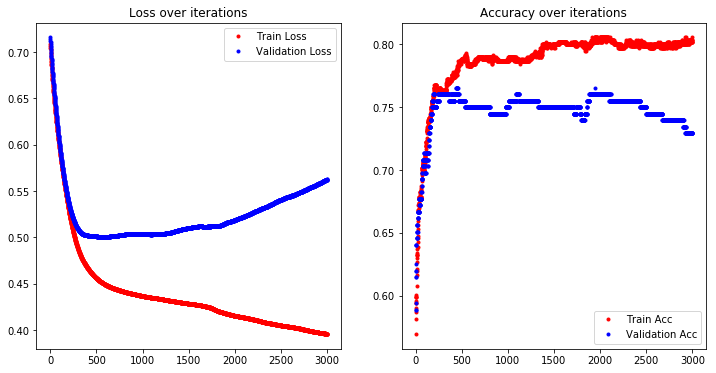

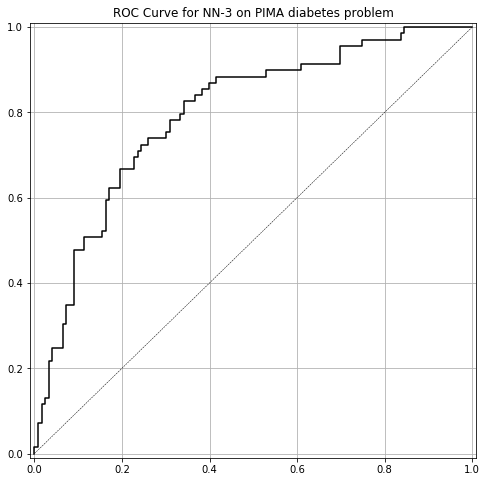

In [33]:
#For the last one, there was not much change in accuracy but the rocauc score increased


#experimenting with different values

#Creating Model with 2 hidden layers, each has 6 nodes and relu activation 
#The final layers has 1 node and sigmoid activation

model_3 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, input_shape=(8,),activation="relu"), 
    Dense(1, activation="sigmoid")
]) 

#This function summarizes the details of the model 
model_3.summary()

#Experimenting with a new learning rate and a different number of epochs
#Compiling the model with lr=0.006, training for 500 epochs 
model_3.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_4 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=3000)


#plotting values 
n = len(run_hist_4.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist_4.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist_4.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist_4.history["acc"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist_4.history["val_acc"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

y_pred_class_nn_4 = model_3.predict_classes(X_test_norm)
y_pred_prob_nn_4 = model_3.predict(X_test_norm)
print('')
print('accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_4)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_4)))

plot_roc(y_test, y_pred_prob_nn_4, 'NN-3')
